In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [3]:
config_file = '../snakemake/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [4]:
filt_ab = '../'+expand(config['data']['filt_ab'], species='human')[0]
lib_meta = '../'+expand(config['data']['meta'], species='human')[0]
cerberus_h5 = '../'+expand(config['data']['cerb_annot'], species='human')[0]
ca_plus = '../'+expand(config['data']['ca_plus'], species='human')[0]
swan_file = '../'+expand(config['data']['sg'], species='human')[0]
gtf = '../'+expand(config['data']['cerb_gtf'], species='human')[0]

phastcons = '../'+config['ref']['phastcons100']['txt']

gene_subset = 'polya'

biosamp_name_map = '../'+expand(config['ref']['biosamp_map'])[0]

cage_meta = '../'+expand(config['cage']['meta'], species='human')[0]
rampage_meta = '../'+expand(config['rampage']['meta'], species='human')[0]

min_tpm = 1
gene_subset = 'polya'

## Conservation

In [24]:
# "parameters"
min_cons_score = 250

In [27]:
# read conserved elements in, threshold for a certain score
cons = pd.read_csv(phastcons, sep='\t', header=None,
                 names=['bin', 'Chromosome', 'Start', 'End', 'idk1', 'score'])
cons = cons[['Chromosome', 'Start', 'End', 'score']]
cons = cons.loc[cons.score >= min_cons_score]
# sns.displot(cons, x='score', kind='kde')
cons = pr.PyRanges(df)

In [43]:
# read gtf, limit to relevant columns
# only look at exons, calc exon len
gtf_df = pr.read_gtf(gtf, duplicate_attr=True, rename_attr=True).as_df()
gtf_df = gtf_df[['Chromosome', 'Start', 'End', 'gene_name',
                 'gene_id', 'transcript_id', 'Feature']]
gtf_df = gtf_df.loc[gtf_df.Feature=='exon']
gtf_df['exon_len'] = (gtf_df.Start-gtf_df.End).abs()

Found attributes with reserved names: ['source'].
Renaming attributes with suffix '_attr'


In [49]:
# temporary - limit to one gene
myog_df = gtf_df.loc[gtf_df.gene_name=='MYOG']

In [50]:
myog_df = pr.PyRanges(myog_df)

In [51]:
myog_df

,Chromosome,Start,End,gene_name,gene_id,transcript_id,Feature,exon_len
0,chr1,203087286,203087483,MYOG,ENSG00000122180.4,"ENSG00000122180[2,3,1]",exon,197
1,chr1,203085490,203085877,MYOG,ENSG00000122180.4,"ENSG00000122180[2,3,1]",exon,387
2,chr1,203084646,203084728,MYOG,ENSG00000122180.4,"ENSG00000122180[2,3,1]",exon,82
3,chr1,203083078,203084031,MYOG,ENSG00000122180.4,"ENSG00000122180[2,3,1]",exon,953
4,chr1,203084646,203086062,MYOG,ENSG00000122180.4,"ENSG00000122180[1,2,1]",exon,1416
5,chr1,203083078,203084031,MYOG,ENSG00000122180.4,"ENSG00000122180[1,2,1]",exon,953
6,chr1,203085490,203086062,MYOG,ENSG00000122180.4,"ENSG00000122180[1,1,1]",exon,572
7,chr1,203084646,203084728,MYOG,ENSG00000122180.4,"ENSG00000122180[1,1,1]",exon,82
8,chr1,203083078,203084031,MYOG,ENSG00000122180.4,"ENSG00000122180[1,1,1]",exon,953


In [52]:
myog_df = myog_df.join(cons, report_overlap=True)

In [53]:
myog_df

,Chromosome,Start,End,gene_name,gene_id,transcript_id,Feature,exon_len,bin,Start_b,End_b,idk1,score,Overlap
0,chr1,203085490,203085877,MYOG,ENSG00000122180.4,"ENSG00000122180[2,3,1]",exon,387,2134,203085480,203085493,lod=44,368,3
1,chr1,203085490,203085877,MYOG,ENSG00000122180.4,"ENSG00000122180[2,3,1]",exon,387,2134,203085494,203085499,lod=35,345,5
2,chr1,203085490,203085877,MYOG,ENSG00000122180.4,"ENSG00000122180[2,3,1]",exon,387,2134,203085517,203085529,lod=91,440,12
3,chr1,203085490,203085877,MYOG,ENSG00000122180.4,"ENSG00000122180[2,3,1]",exon,387,2134,203085530,203085559,lod=334,568,29
4,chr1,203085490,203085877,MYOG,ENSG00000122180.4,"ENSG00000122180[2,3,1]",exon,387,2134,203085560,203085636,lod=927,669,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,chr1,203083078,203084031,MYOG,ENSG00000122180.4,"ENSG00000122180[1,1,1]",exon,953,2134,203084003,203084005,lod=29,327,2
183,chr1,203083078,203084031,MYOG,ENSG00000122180.4,"ENSG00000122180[1,1,1]",exon,953,2134,203084006,203084007,lod=15,262,1
184,chr1,203083078,203084031,MYOG,ENSG00000122180.4,"ENSG00000122180[1,1,1]",exon,953,2134,203084009,203084014,lod=49,379,5
185,chr1,203083078,203084031,MYOG,ENSG00000122180.4,"ENSG00000122180[1,1,1]",exon,953,2134,203084015,203084017,lod=19,285,2


In [81]:
# myog_df = myog_df.df

# get len covered in each exon
keep_cols = ['Chromosome', 'Start', 'End', 'gene_name', 'gene_id', 'transcript_id', 'exon_len', 'Overlap']
gb_cols = ['Chromosome', 'Start', 'End', 'gene_name', 'gene_id', 'transcript_id', 'exon_len']
temp = myog_df[keep_cols].groupby(gb_cols, observed=True).sum().reset_index().rename({'Overlap': 'cons_len'}, axis=1)

In [83]:
# get total len of transcript and len covered of each transcript 
keep_cols = ['gene_name', 'gene_id', 'transcript_id', 'exon_len', 'cons_len']
gb_cols = ['gene_name', 'gene_id', 'transcript_id']
temp = temp[keep_cols].groupby(gb_cols,observed=True).sum().reset_index().rename({'exon_len': 't_len'}, axis=1)

In [84]:
temp.head()

,gene_name,gene_id,transcript_id,t_len,cons_len
0,MYOG,ENSG00000122180.4,"ENSG00000122180[1,1,1]",1607,1019
1,MYOG,ENSG00000122180.4,"ENSG00000122180[1,2,1]",2369,1039
2,MYOG,ENSG00000122180.4,"ENSG00000122180[2,3,1]",1422,849


In [ ]:
# now get median % exonic conservation per gene
temp['perc_cons'] = (temp['cons_len']/temp['t_len'])*100
keep_cols = ['gene_name', 'gene_id', 'perc_cons']
gb_cols = ['gene_name', 'gene_id']
temp = temp[keep_cols].groupby(gb_cols).median().reset_index().rename({'perc_cons':'med_perc_cons'}, axis=1)

In [28]:
# myog_df = gtf_df.loc[gtf_df.gene_name == 'MYOG']
# myog_df = myog_df.loc[myog_df.Feature=='exon'][['Chromosome', 'Start', 'End']]
# myog_df = pr.PyRanges(myog_df)
# temp = myog_df.join(cons, report_overlap=True)
# sns.displot(temp, x='score')

In [23]:
cons.loc[cons.score<250]

,bin,Chromosome,Start,End,idk1,score
12,585,chr1,12985,12992,lod=13,247
18,585,chr1,13060,13062,lod=13,247
31,585,chr1,14118,14127,lod=13,247
33,585,chr1,14179,14184,lod=13,247
46,585,chr1,14798,14800,lod=12,240
...,...,...,...,...,...,...
10350657,1021,chrY,57195484,57195541,lod=13,247
10350660,1021,chrY,57196338,57196341,lod=13,247
10350673,1021,chrY,57208720,57208727,lod=13,247
10350705,1021,chrY,57211798,57211800,lod=13,247


In [18]:
temp = temp.df

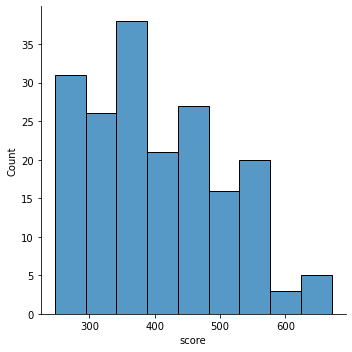

In [20]:
# get the exons from the reference GTF
gtf_df = pr.read_gtf(gtf, as_df=True, duplicate_attr=True, rename_attr=True)

Found attributes with reserved names: ['source'].
Renaming attributes with suffix '_attr'


In [15]:
s = 'splicing'
source = 'obs_major'
df = ca.triplets.loc[(ca.triplets.source==source)&(ca.triplets.sector==s)]

In [16]:
df.head()

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,gname,sample,gene_tpm,dataset
12,obs_major,ENSG00000001497,1.0,2.0,7.0,7.0,4.666667,0.130435,0.260870,0.608696,splicing,LAS1L,NaN,NaN,NaN
20,obs_major,ENSG00000002330,1.0,1.0,3.0,3.0,3.000000,0.200000,0.200000,0.600000,splicing,BAD,NaN,NaN,NaN
22,obs_major,ENSG00000002586,1.0,2.0,5.0,5.0,3.333333,0.157895,0.315789,0.526316,splicing,CD99,NaN,NaN,NaN
51,obs_major,ENSG00000004487,2.0,1.0,7.0,7.0,4.666667,0.260870,0.130435,0.608696,splicing,KDM1A,NaN,NaN,NaN
84,obs_major,ENSG00000005189,1.0,2.0,8.0,9.0,5.333333,0.120000,0.240000,0.640000,splicing,REXO5,NaN,NaN,NaN


In [20]:
cons = cons.df

In [22]:
cons.loc[cons.score < 300]
cons.score.min()

186

## GO terms

In [4]:
def do_go_thing(df, opref):
    dbs = ['GO_Biological_Process_2021',
       'GO_Cellular_Component_2021',
       'GO_Molecular_Function_2021',
       'KEGG_2021_Human']
    bm = gp.parser.Biomart()
    datasets = bm.get_datasets(mart='ENSEMBL_MART_ENSEMBL')
    datasets.loc[datasets.Description.str.contains('Human')]
    
    for s in df.sector.unique():
        print(s)
        desc = '{} genes'.format(s)
        odir = '{}{}_genes_GO'.format(opref, s)
        gids = df.loc[df.sector == s, 'gid'].tolist()
        gids = bm.query(dataset='hsapiens_gene_ensembl',
               attributes=['ensembl_gene_id', 'external_gene_name'],
               filters={'ensembl_gene_id': gids})
        gids = gids.loc[~gids.external_gene_name.isna()]
        gnames = gids.external_gene_name.squeeze().str.strip().tolist()
        go = gp.enrichr(gene_list=gnames,
                        gene_sets=dbs,
                        organism='Human',
                        description=desc,
                        outdir=odir,
                        cutoff=0.5)

In [5]:
ca = cerberus.read(cerberus_h5)

In [8]:
source = 'obs_major'
df = ca.triplets.loc[ca.triplets.source == source]

# limit to protein coding genes
gtf_df, _, _ = get_gtf_info(how='gene', ver='v40_cerberus')
gtf_df['gid_stable'] = cerberus.get_stable_gid(gtf_df, col='gid')
gids = gtf_df.loc[gtf_df.biotype_category=='protein_coding', 'gid_stable'].tolist()
print(len(df.index))
df = df.loc[df.gid.isin(gids)]
print(len(df.index))

26781
17523


In [9]:
do_go_thing(df, 'obs_major_')

tes
simple
mixed
tss
splicing


In [10]:
def rm_go_number(df):
    df['term'] = df['Term'].str.split('\(GO', expand=True)[0]
    return df

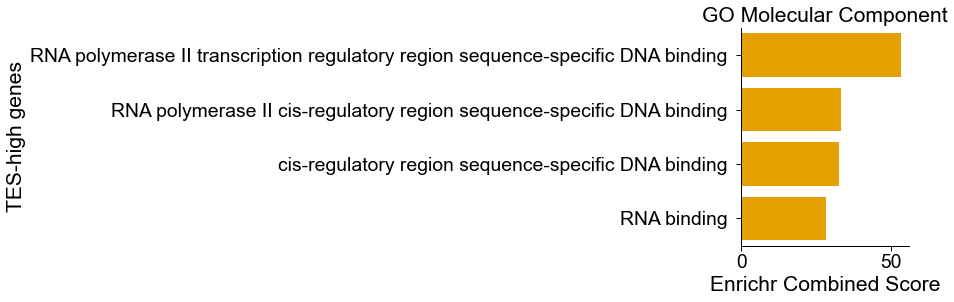

In [11]:
# tes - show molecular function
df = pd.read_csv('obs_major_tes_genes_GO/GO_Molecular_Function_2021.Human.enrichr.reports.txt', sep='\t')
n = 4
kind = 'tes'
df = df.head(n)
df = rm_go_number(df)
color = get_sector_colors()[0][kind]


sns.set_context('paper', font_scale=2.2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(3,4))
ax = sns.barplot(data=df, x='Combined Score', y='term', color=color, saturation=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(title='GO Molecular Component')

xlabel = 'Enrichr Combined Score'
ylabel = 'TES-high genes'

_ = ax.set(xlabel=xlabel, ylabel=ylabel)
fname = 'obs_major_tes_genes_GO/molecular_component_bar.pdf'
plt.savefig(fname, dpi=500, bbox_inches='tight')

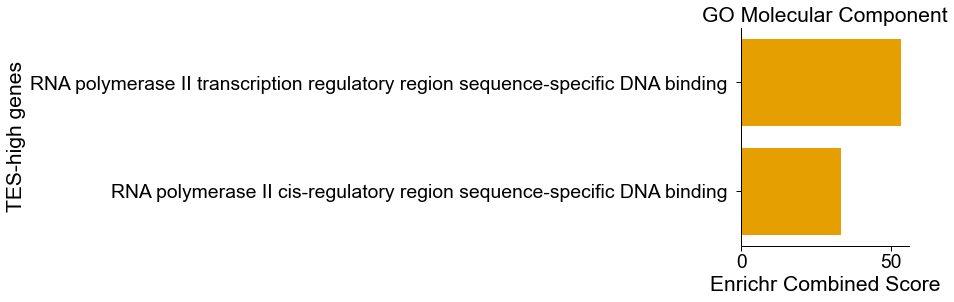

In [12]:
# tes - show molecular function
df = pd.read_csv('obs_major_tes_genes_GO/GO_Molecular_Function_2021.Human.enrichr.reports.txt', sep='\t')
n = 2
kind = 'tes'
df = df.head(n)
df = rm_go_number(df)
color = get_sector_colors()[0][kind]


sns.set_context('paper', font_scale=2.2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(3,4))
ax = sns.barplot(data=df, x='Combined Score', y='term', color=color, saturation=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(title='GO Molecular Component')

xlabel = 'Enrichr Combined Score'
ylabel = 'TES-high genes'

_ = ax.set(xlabel=xlabel, ylabel=ylabel)
fname = 'obs_major_tes_genes_GO/molecular_component_bar.pdf'
plt.savefig(fname, dpi=500, bbox_inches='tight')

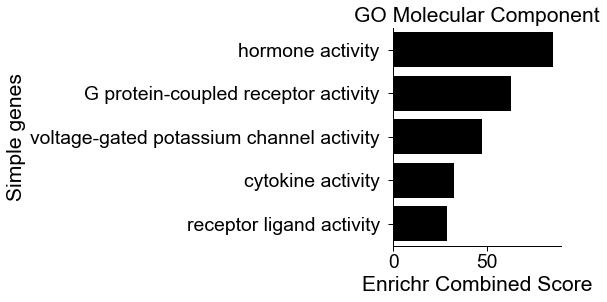

In [13]:
# simple - show molecular function
df = pd.read_csv('obs_major_simple_genes_GO/GO_Molecular_Function_2021.Human.enrichr.reports.txt', sep='\t')
n = 5
kind = 'simple'
df = df.head(n)
df = rm_go_number(df)
df = df.sort_values(by='Combined Score', ascending=False)
color = get_sector_colors()[0][kind]


sns.set_context('paper', font_scale=2.2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(3,4))
ax = sns.barplot(data=df, x='Combined Score', y='term', color=color, saturation=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(title='GO Molecular Component')

xlabel = 'Enrichr Combined Score'
ylabel = 'Simple genes'

_ = ax.set(xlabel=xlabel, ylabel=ylabel)
fname = 'obs_major_simple_genes_GO/molecular_component_bar.pdf'
plt.savefig(fname, dpi=500, bbox_inches='tight')

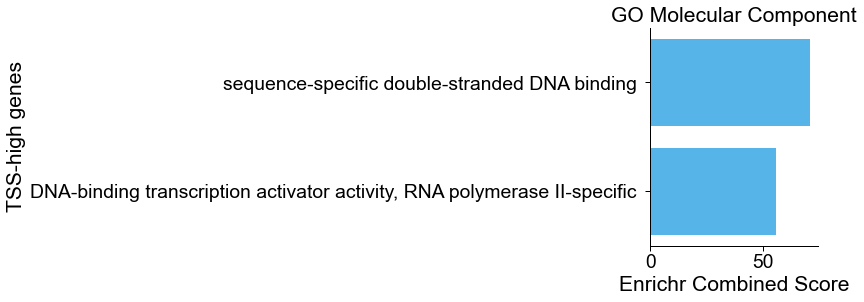

In [14]:
# simple - show molecular function
df = pd.read_csv('obs_major_tss_genes_GO/GO_Molecular_Function_2021.Human.enrichr.reports.txt', sep='\t')
n = 6
kind = 'tss'
df = df.iloc[[0,3]]
df = rm_go_number(df)
df = df.sort_values(by='Combined Score', ascending=False)
color = get_sector_colors()[0][kind]


sns.set_context('paper', font_scale=2.2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(3,4))
ax = sns.barplot(data=df, x='Combined Score', y='term', color=color, saturation=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(title='GO Molecular Component')

xlabel = 'Enrichr Combined Score'
ylabel = 'TSS-high genes'

_ = ax.set(xlabel=xlabel, ylabel=ylabel)
fname = 'obs_major_tss_genes_GO/molecular_component_bar.pdf'
plt.savefig(fname, dpi=500, bbox_inches='tight')